In [1]:
#Start by creating the dataset. We want to make a system for the potential *not* including
#the eigen functions explicitly. But we first estimate the wavefns or what gaussians they resemble.

#Import libraries
%matplotlib widget
import numpy as np 
import torch
from scipy.integrate import simps
import pickle
import scipy.stats as stats

In [2]:
#Import helper functions 

from FourierGridMethod import Fourier_Grid,normalize_wfn,side_wp,FourierGridHamiltonian
from Generate_fields import random_perturbation
from potfields import potential,electric_field,alpha,complete_simulation,chirped_pulse
from new_split import split_op
from plot_utils import animate_dyn,plot_eig,plot_perturbation,plot_wavepacket
from bayesian import prior

In [3]:
#Setting variables for the simulation
#the hamiltonian for the system is 

# Define the x and y coordinates of the grid

x_min, x_max = -90*np.pi/180, 90*np.pi/180
y_min, y_max = 0, 7.25
x_size, y_size = 300, 300

#Define x and y grids
x_grid = np.linspace(x_min, x_max, x_size)
y_grid = np.linspace(y_min, y_max, y_size)

#Define meshgrid terms for 3D plots and making perturbations
x_dim, t_dim = np.meshgrid(x_grid, y_grid)


In [4]:
rng = np.random.RandomState(seed=123)

#Scale for unit conversion to au
ev_scale=1/(27*1e3)

#Values for inertia 
IBr=8911925
IF=1864705

#Calculate Irel
Irel=(IBr*IF)/(IBr+IF)

In [5]:
#Generate the double well potential
V_pot=potential(x_grid,y_grid)

#this pot is in ev therefore we need to convert that to au so we multiply this by 1/27
V_pot_au=V_pot*(1/27)
#%matplotlib inline
#V_plot=plot_perturbation(x_grid,y_grid,V_pot)

In [6]:
#coherence and variance in amplitude for term1
phi_coh_x = 12.2
phi_coh_y = 0.27
phi_amp_var=11.9

#Generate the n_v term and plot it. This term is in meV
phi_perturb=random_perturbation(x_size,y_size,phi_coh_x,phi_coh_y,phi_amp_var)
# We convert this to au by multiplying it by /27*10e3
phi_perturb_au=(1/27*1e3)*(phi_perturb)
#%matplotlib inline
#phi_noise_plot=plot_perturbation(x_grid,y_grid,phi_perturb)



In [7]:
#Add the two terms and compute fourier grid hamiltonian at steps t=0 and t=T
#These serve as the initial wavepacket for the laser system, and the final wavepacket for the comparision
nstates=20
V_vib=V_pot_au+phi_perturb_au
#V_vib_ev=ev_scale*(V_pot+phi_perturb)

#FGH at step 0
E0,psi0=Fourier_Grid(Irel,x_size,x_max-x_min,V_vib[0])
test_wf=normalize_wfn(psi0,x_grid,5)

alpha_1=np.vectorize(alpha)(x_grid)

Et,psit=Fourier_Grid(Irel,x_size,x_max-x_min,V_vib[y_size-1])
psit=normalize_wfn(psi0,x_grid,nstates)
    
psi_start=side_wp(psi0,-1)
psi_ref=side_wp(psit,1)
    
pot_params={'psi_start':psi_start,'psi_ref':psi_ref,'V_vib':V_vib,'alpha':alpha_1, 'I_rel': Irel}


0.009727305886810018
0.009727305886810018


In [9]:
# A0 = 1                    # Peak amplitude #Variable range (1,5)
# t0 = 3*990                      # Center time #fixed
# sigma = t0               # Standard deviation #variable (0.5,2)
# f0 = 0                      # Central frequency #variable (2,5)
# beta =0.0005                # Chirp rate fixed
# phi = 1.51*np.pi   

t0=3*990


param_1 = 1.0 # initial value for the first field parameter which is amplitude
param_2 = 1.0 # initial value for the second field parameter which center time
param_3=2.0
params = [param_1, param_2,param_3] # current parameter values

# Define the range bounds for the parameters
param_1_bounds = [0, 1] #max_x
param_2_bounds = [1*990, 5*990] #max_y*
param_3_bounds = [0.7*t0, 1.2*t0] #sigma


pp=0.1
t0=3.5



param_1_prior = stats.truncnorm((param_1_bounds[0] - np.mean(param_1_bounds)) / np.std(param_1_bounds),
                                (param_1_bounds[1] - np.mean(param_1_bounds)) / np.std(param_1_bounds),
                                loc=np.mean(param_1_bounds),
                                scale=np.std(param_1_bounds))
param_2_prior = stats.truncnorm((param_2_bounds[0] - np.mean(param_2_bounds)) / np.std(param_2_bounds),
                                (param_2_bounds[1] - np.mean(param_2_bounds)) / np.std(param_2_bounds),
                                loc=np.mean(param_2_bounds),
                                scale=np.std(param_2_bounds))
param_3_prior = stats.truncnorm((param_3_bounds[0] - np.mean(param_3_bounds)) / np.std(param_3_bounds),
                                (param_3_bounds[1] - np.mean(param_3_bounds)) / np.std(param_3_bounds),
                                loc=np.mean(param_3_bounds),
                                scale=np.std(param_3_bounds))


#max_x=4.5
#max_y=5
#max_pp=0.1
#sigma=1
#t0=3.5
 

    
# k_curr= max_x
# k1_curr= max_y
# t_curr=max_pp
# phi=np.pi

#chirped_pulse(t_dim, k, t0, sig, k1, t1, phi)
#prop_f_params= {'sig':sigma,'t0':t0,'t1':t_curr,'k':k_curr,'k1':k1_curr}



In [10]:
#from scipy.stats import norm
#from scipy.optimize import curve_fit
#(muf, stdf), covf = curve_fit(norm.pdf, x_grid, test_wf[:,0], p0=[0, 1])

#(mu, sigma) = norm.fit(test_wf[:,0])

In [11]:
U_fin=[]
D_fin=[]
ux_fin=[]
V_fin=[]

In [12]:
n_samp=10
ntrain=90
timestep=990
rabi=split_op(xmin=x_min,xmax=x_max,Nx=x_size,nt=y_size,dt=timestep,t_end=timestep*y_size, device=None,dtype=torch.float64)
V_set=[]
u_set=[]
U_set=[]
D_set=[]
ux_set=[]
#from functorch import vmap, grad

for i in range(n_samp):
    
    
    prop_params = prior(param_1_prior,param_2_prior,param_3_prior)
    #prop_params=[5,5,1]
    
    p1_prop=prop_params[0]
    p2_prop=prop_params[1]
    p3_prop=prop_params[2]
    
    t0_prop=3.5
    pp=0.1
    
   # k_prop=4.894472361809045
   # k1_prop=2.2562814070351758
   # t_prop=3.869346733668342
        
    
    #4.894472361809045 2.2562814070351758 3.869346733668342
    
    curr_f_params= {'sig':p3_prop,'t0':t0_prop,'t1':pp,'k':p2_prop,'k1':p1_prop}
    task='gen'

    U,D,ux,V=complete_simulation(task,x_grid,y_grid,pot_params,curr_f_params)

    
    #u0=(torch.from_numpy(gaussian_approximation)).to(torch.complex64)
    
    V_vib=torch.from_numpy(V)
    #U,D,ux=rabi.split_op(u0,V_vib)
    
    u_set.append(torch.from_numpy(psi_start))
    V_set.append(V_vib)
    U_set.append(U)
    D_set.append(D)
    ux_set.append(ux)
   
V=torch.stack(V_set)
u0=torch.stack(u_set)
u0 = u0.to(torch.complex64)
ux=torch.stack(ux_set)
U=torch.stack(U_set)
#U,D,ux=torch.vmap(rabi.split_op)(u0,V)
U_real=torch.view_as_real(U) 
D_save=torch.stack(D_set)


2416.058886073417
4182.848733323107
3213.7502362547134
2427.487440671483
1198.838490217066


/p/project/hai_ml_xas/MCMC/Generate_fields.py:40: RuntimeWarning: invalid value encountered in true_divide
  scaled_noise = (filtered_noise / std_noise) * np.sqrt(amp_var)


1221.7943305518959
2625.634736110661
2989.758566228192
2546.8754513312347
1803.9135801559491


In [13]:
dat_dict={'V': V , 'u0': u0,  'ux':ux, 'U_real':U_real,'gridx':x_grid,'gridt':y_grid}

with open('data.pickle', 'wb') as handle:
    pickle.dump(dat_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
print(U_real.shape)

torch.Size([10, 300, 300, 2])


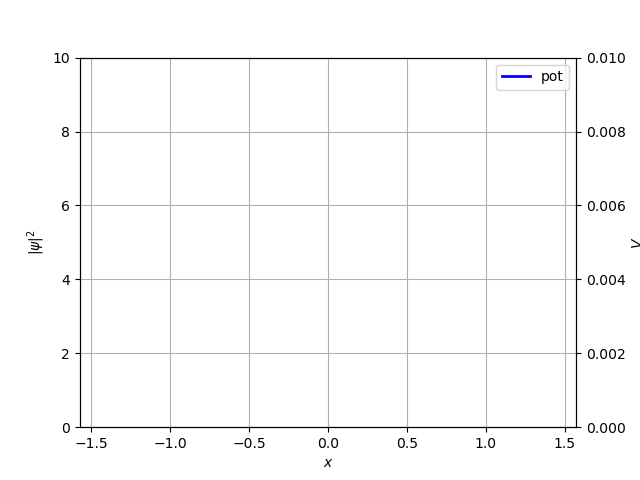

In [15]:

#plot_wavepacket(x_grid,V_vib[0],)
t=animate_dyn(x_min,x_max,0,100,x_grid,D_save[0],V[0])

In [ ]:
print(type(U),type(ux),type(D),type(V_vib))

In [ ]:
test_wf=normalize_wfn(psi0,x_grid,5)

In [ ]:
%matplotlib inline
plot_wavepacket(x_grid,V_vib[0],psi0[:,0])

In [ ]:
psi0[:,0]

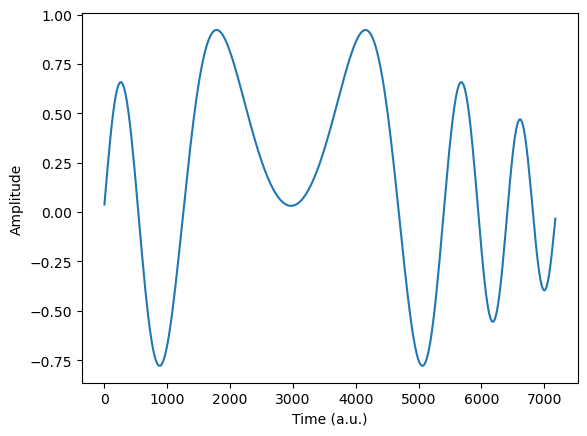

In [41]:
import numpy as np
t = 990*y_grid # Time points
A0 = 1                    # Peak amplitude #Variable range (1,5)
t0 = 3*990                      # Center time #fixed
sigma = t0               # Standard deviation #variable (0.5,2)
f0 = 0                      # Central frequency #variable (2,5)
beta =0.0005                # Chirp rate fixed
phi = 1.51*np.pi                   # Phase offset #fixed
#print(t)
pulse = chirped_pulse(t, A0, t0, sigma, f0, beta, phi)
#print ( A0 * np.exp(-0.5 * ((t - t0) / sigma) ** 2) )
# Plot the pulse
%matplotlib inline
import matplotlib.pyplot as plt
plt.clf()
plt.plot(t, pulse)
plt.xlabel('Time (a.u.)')
plt.ylabel('Amplitude')
plt.show()

In [33]:
print(np.cos(2 * np.pi * (f0 + beta * (t - t0)) * (t - t0)/sigma + phi))

[ 0.92977649  0.55879451 -0.003066   -0.55983546 -0.92477054 -0.98181403
 -0.71965091 -0.22961615  0.32882262  0.78140877  0.99317628  0.90677634
  0.55498025  0.04596448 -0.47195026 -0.85425061 -0.99982028 -0.87570879
 -0.52177014 -0.03581602  0.45502563  0.8281222   0.99534028  0.92221695
  0.63271609  0.1998573  -0.27419719 -0.68298801 -0.93946315 -0.99344036
 -0.8397009  -0.51597585 -0.09230541  0.34514776  0.71200757  0.94162799
  0.99623161  0.87168307  0.59573012  0.22076501 -0.18699332 -0.55961706
 -0.83868843 -0.98386959 -0.97775092 -0.82665632 -0.55777082 -0.2134765
  0.15591834  0.4998019   0.77410919  0.94655019  0.99971786  0.93194248
  0.75607945  0.49666016  0.18597831 -0.14027125 -0.44722639 -0.70449561
 -0.88887612 -0.9859859  -0.99079211 -0.90714195 -0.74649116 -0.52607644
 -0.26679308  0.00897607  0.27937207  0.52475535  0.72898571  0.88024303
  0.97139419  0.99994981  0.9676821   0.87998987  0.74510157  0.57320317
  0.37556694  0.16374279 -0.0511429  -0.25895258 -0.

In [31]:
2 * np.pi * (f0 + beta * (t - t0)) * (t - t0)/sigma

array([-18623.7382416 , -18473.51114697, -18323.27917607, -18173.04232891,
       -18022.80060548, -17872.55400579, -17722.30252983, -17572.0461776 ,
       -17421.78494911, -17271.51884435, -17121.24786332, -16970.97200602,
       -16820.69127246, -16670.40566264, -16520.11517654, -16369.81981418,
       -16219.51957556, -16069.21446066, -15918.9044695 , -15768.58960208,
       -15618.26985838, -15467.94523843, -15317.6157422 , -15167.28136971,
       -15016.94212095, -14866.59799592, -14716.24899463, -14565.89511707,
       -14415.53636325, -14265.17273315, -14114.8042268 , -13964.43084417,
       -13814.05258528, -13663.66945012, -13513.2814387 , -13362.88855101,
       -13212.49078705, -13062.08814683, -12911.68063034, -12761.26823758,
       -12610.85096856, -12460.42882327, -12310.00180171, -12159.56990389,
       -12009.1331298 , -11858.69147944, -11708.24495282, -11557.79354993,
       -11407.33727077, -11256.87611535, -11106.41008366, -10955.93917571,
       -10805.46339148, -